# Data Preprocessing and Causal Graph Construction

### Goal
The purpose of this notebook is to construct the complete, analysis-ready dataset for our causal GNN. This involves three key stages:


1.  Define our Causal Hypothesis: We will explicitly lay out the causal graph we aim to model.

2.  Acquire and Process Data: We will download raw financial data and compute the necessary metrics for each variable in our graph

3.  Generate Final Files: We will create the final nodes.csv, edges.csv, and features.csv that our model will use for training.



## The Causal Graph: Our Hypothesis
We will model a specific, hypothesized chain of causal events based on the literature on causal factor investing.

**The Variables (Nodes):** 
* Mom & HML: Market-wide factors (Momentum and Value).
* OI & PC & BAS: Microstructure variables capturing trading activity (Order Imbalance, Price Change, Bid-Ask Spread).
* LIQ & VOL: Final market outcomes (Liquidity and Volatility), which are our prediction targets.

Edges (The Causal Links):

Mom -> HML

Mom -> PC

HML -> OI

OI -> PC

OI -> BAS

PC -> BAS

BAS -> LIQ

BAS -> VOL


Our goal is to build a model that can understand and forecast market risk and stability. Volatility (VOL) and Liquidity (LIQ) are two of the most critical, real-world indicators of market health. They are the ultimate outcomes of the complex interactions between market factors and trading behavior. By setting them as our targets, we are testing if our causal model can learn the underlying mechanisms that lead to these crucial market states. 


### The Data Plan
To get data for these abstract nodes, we will use a market proxy—the SPDR S&P 500 ETF (SPY)—to calculate all price-derived and microstructure variables. The factor data comes directly from the Kenneth French Data Library. All required metrics can be calculated from simple daily data.


In [32]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

# config
MARKET_PROXY_TICKER = "SPY"
ALL_NODES = ["Mom", "HML", "OI", "PC", "BAS", "LIQ", "VOL"]
START_DATE = "2000-01-01"
END_DATE = "2023-12-31"
VOL_WINDOW = 21
ROLL_SPREAD_WINDOW = 21

# Find the project root directory by going up one level from the notebook's directory
# This makes the notebook runnable from anywhere in the project.
PROJECT_ROOT = Path().resolve().parent
OUTPUT_DIR = PROJECT_ROOT / "data" / "processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Project Root detected at: {PROJECT_ROOT}")
print(f"Libraries loaded. Output will be saved to '{OUTPUT_DIR}'")


Project Root detected at: C:\Users\asus\OneDrive\Desktop\thesis
Libraries loaded. Output will be saved to 'C:\Users\asus\OneDrive\Desktop\thesis\data\processed'


In [33]:
#helper functions 
def compute_returns(df, price_col):
    return df[price_col].pct_change()

def compute_rolling_vol(returns, window=21):
    return returns.rolling(window=window, min_periods=window).std()

def compute_amihud(return_series, dollar_volume_series):
    return (return_series.abs() / (dollar_volume_series + 1e-9)).fillna(0.0)

def compute_signed_volume(return_series, dollar_volume_series):
    return np.sign(return_series).fillna(0) * dollar_volume_series

def compute_roll_spread(price_series, window=21):
    dp = price_series.diff()
    dp_lag = dp.shift(1)
    cov = dp.rolling(window=window).cov(dp_lag)
    spread = 2.0 * np.sqrt((-cov).clip(lower=0.0))
    return spread.fillna(0.0)


In [34]:
print("Downloading Fama-French 3 Factors and Momentum Factor (Daily)...")
ff_3_factor = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=START_DATE, end=END_DATE)[0]
ff_mom_factor = pdr.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start=START_DATE, end=END_DATE)[0]


# --- ROBUST DATA CLEANING ---
# Combine and clean the factor data
ff_factors = ff_3_factor.join(ff_mom_factor, how='inner')
ff_factors /= 100.0

ff_factors = ff_factors[['HML', 'Mom']].copy()
print("Fama-French data downloaded successfully.")

print(f"\nDownloading market proxy data for {MARKET_PROXY_TICKER}...")
market_data_raw = yf.download(MARKET_PROXY_TICKER, start=START_DATE, end=END_DATE)
print("Market proxy data downloaded successfully.")

if isinstance(market_data_raw.columns, pd.MultiIndex):
    # If it's a MultiIndex, select the data for our ticker and drop the extra level
    market_data = market_data_raw.xs(MARKET_PROXY_TICKER, level='Ticker', axis=1).copy()
else:
    market_data = market_data_raw.copy()

market_data.head()


C:\Users\asus\AppData\Local\Temp\ipykernel_1852\106672671.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_3_factor = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=START_DATE, end=END_DATE)[0]
C:\Users\asus\AppData\Local\Temp\ipykernel_1852\106672671.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_mom_factor = pdr.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start=START_DATE, end=END_DATE)[0]
[*********************100%***********************]  1 of 1 completed

Fama-French data downloaded successfully.

Market proxy data downloaded successfully.


Price,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,92.142525,93.924396,91.152596,93.924396,8164300
2000-01-04,88.539185,91.271387,88.469890,90.934811,8089800
2000-01-05,88.697578,89.667708,86.955305,88.657981,12177900
2000-01-06,87.272057,89.647884,87.272057,88.459970,6227200
2000-01-07,92.340538,92.340538,88.737198,88.895587,8066500


In [35]:
price_col = 'Price' if 'Price' in market_data.columns else 'Close'
print(f"\nUsing '{price_col}' as the primary price column for calculations.")

market_data['pc'] = compute_returns(market_data, price_col=price_col)
market_data['vol'] = compute_rolling_vol(market_data['pc'], window=VOL_WINDOW)
market_data['dollarvolume'] = market_data[price_col] * market_data['Volume']
market_data['liq'] = compute_amihud(market_data['pc'], market_data['dollarvolume'])
market_data['bas'] = compute_roll_spread(market_data[price_col], window=ROLL_SPREAD_WINDOW)
market_data['oi'] = compute_signed_volume(market_data['pc'], market_data['dollarvolume'])

# Rename columns to match our final node names for clarity
market_data.rename(columns={
    'pc': 'PC', 'vol': 'VOL', 'liq': 'LIQ', 'bas': 'BAS', 'oi': 'OI'
}, inplace=True)

# Join the factor data with the calculated microstructure data
final_df_wide = ff_factors.join(market_data, how='inner').dropna()
final_df_wide = final_df_wide[ALL_NODES]
print("\nAll node values calculated and aligned.")
final_df_wide.head()



Using 'Close' as the primary price column for calculations.

All node values calculated and aligned.


,Mom,HML,OI,PC,BAS,LIQ,VOL
Date,,,,,,,
2000-02-02,0.0079,-0.0030,5.546257e+08,0.000887,0.000000,1.599106e-12,0.021141
2000-02-03,0.0095,-0.0145,7.255095e+08,0.015065,1.622347,2.076420e-11,0.019533
2000-02-04,0.0104,-0.0072,-4.449650e+08,-0.004146,1.646427,9.318557e-12,0.019569
2000-02-07,0.0090,-0.0133,-5.273043e+08,-0.001535,1.633067,2.910363e-12,0.019187
2000-02-08,0.0161,-0.0172,4.513340e+08,0.013609,1.088404,3.015245e-11,0.014554


In [36]:
# --- 1. features.csv ---
features_long = final_df_wide.reset_index().melt(
    id_vars='Date', value_vars=ALL_NODES, var_name='node_id', value_name='value')
features_long.rename(columns={'Date': 'date'}, inplace=True)
features_long['date'] = pd.to_datetime(features_long['date']).dt.strftime("%Y-%m-%d")
features_path = OUTPUT_DIR / "features.csv"
features_long.to_csv(features_path, index=False)
print(f"Saved features.csv to {features_path}")

# --- 2. nodes.csv ---
nodes_df = pd.DataFrame({'node_id': ALL_NODES})
nodes_path = OUTPUT_DIR / "nodes.csv"
nodes_df.to_csv(nodes_path, index=False)
print(f"Saved nodes.csv to {nodes_path}")

# --- 3. edges.csv ---
edges_list = [
    {'source': 'Mom', 'target': 'HML'}, {'source': 'Mom', 'target': 'PC'},
    {'source': 'HML', 'target': 'OI'},  {'source': 'OI', 'target': 'PC'},
    {'source': 'OI', 'target': 'BAS'},  {'source': 'PC', 'target': 'BAS'},
    {'source': 'BAS', 'target': 'LIQ'}, {'source': 'BAS', 'target': 'VOL'},
]
edges_df = pd.DataFrame(edges_list)
edges_path = OUTPUT_DIR / "edges.csv"
edges_df.to_csv(edges_path, index=False)
print(f"Saved edges.csv to {edges_path}")

Saved features.csv to C:\Users\asus\OneDrive\Desktop\thesis\data\processed\features.csv
Saved nodes.csv to C:\Users\asus\OneDrive\Desktop\thesis\data\processed\nodes.csv
Saved edges.csv to C:\Users\asus\OneDrive\Desktop\thesis\data\processed\edges.csv



--- Visualizing the Constructed Causal Graph ---


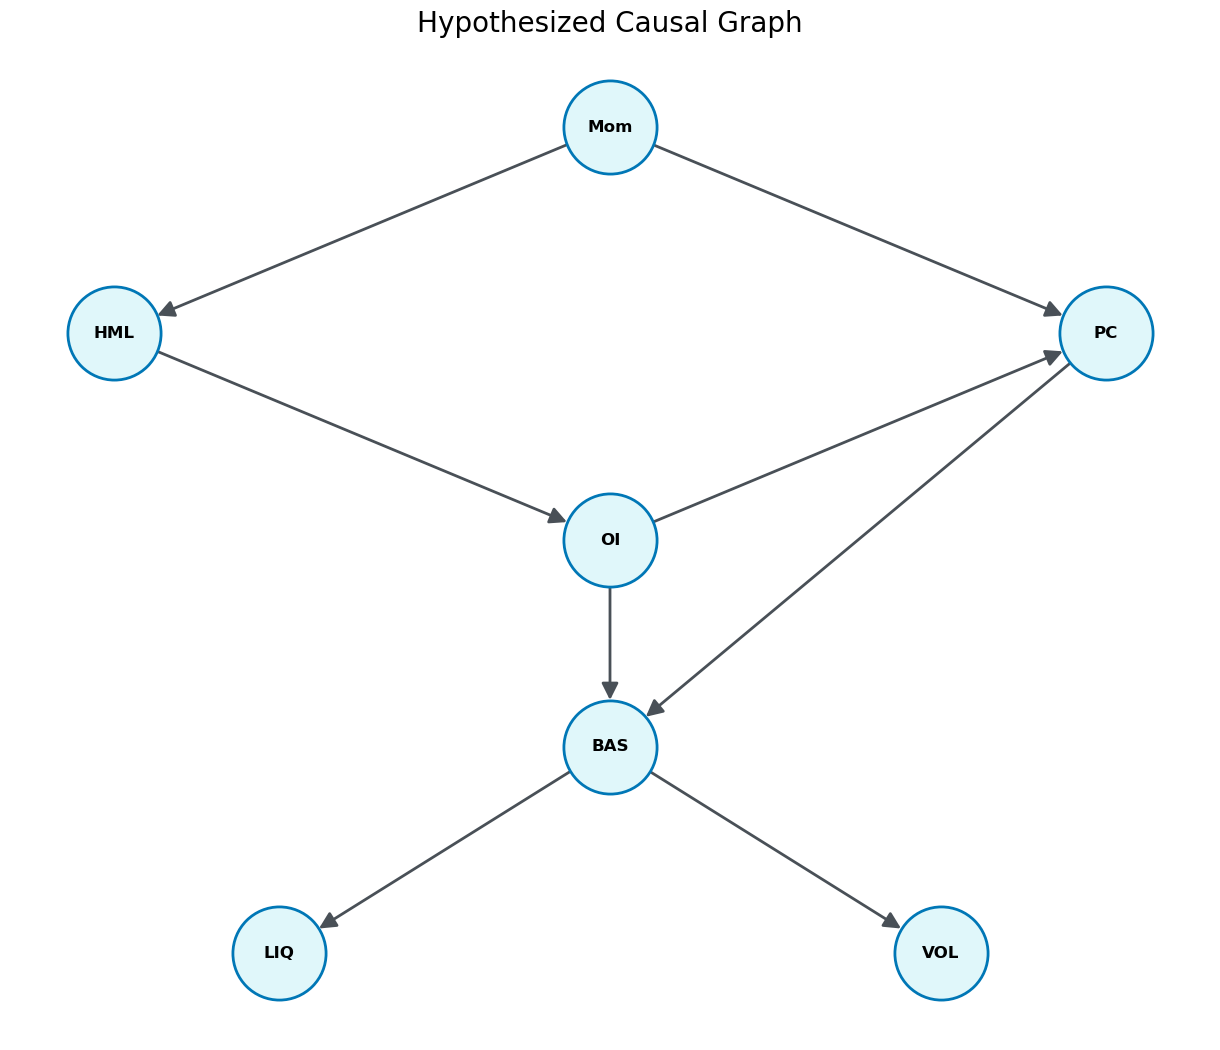

In [37]:
print("\n--- Visualizing the Constructed Causal Graph ---")

# --- 1. Create the Graph Object ---
G = nx.DiGraph()
G.add_nodes_from(nodes_df['node_id'])
G.add_edges_from(edges_df.values)

# --- 2. Define a Manual Hierarchical Layout ---
# We explicitly set the (x, y) coordinates for each node to ensure a clean,
# top-to-bottom causal flow. This gives us full control over the visualization.
pos = {
    'Mom': (0, 4),      # Top layer (Root Cause)
    'HML': (-1.5, 3),   # Mid-layer 1
    'PC':  (1.5, 3),
    'OI':  (0, 2),      # Mid-layer 2
    'BAS': (0, 1),      # Mid-layer 3
    'LIQ': (-1, 0),     # Bottom layer (Outcomes)
    'VOL': (1, 0)
}

# --- 3. Define Drawing Options for a Professional Look ---
plt.figure(figsize=(12, 10))
node_options = {
    "node_size": 4500,
    "node_color": "#e0f7fa",
    "edgecolors": "#0077b6",
    "linewidths": 2.0,
}
label_options = {
    "font_size": 12,
    "font_weight": "bold",
}
# --- ANNOTATION: THE CRITICAL FIX IS HERE ---
# We now specify the arrow style and size directly in the drawing call
# to ensure the directionality of the graph is clearly visible.
edge_options = {
    "width": 2.0,
    "edge_color": "#495057",
    "arrowstyle": "-|>",  # A standard, filled arrow head
    "arrowsize": 25,
}

# --- 4. Draw the Graph ---
# We use the main nx.draw() function which handles directed edges better by default
# when given the correct styling options.
nx.draw(
    G,
    pos,
    with_labels=True,
    **node_options,
    font_size=label_options["font_size"],
    font_weight=label_options["font_weight"],
    **edge_options
)

plt.title("Hypothesized Causal Graph", size=20)
plt.axis('off') # Hide the x and y axes for a cleaner look
plt.show()


In [38]:
print("\n--- Preprocessing Complete ---")
print(f"Total nodes: {len(nodes_df)}")
print(f"Total causal edges: {len(edges_df)}")
print(f"Date range: {final_df_wide.index.min().date()} to {final_df_wide.index.max().date()}")
print(f"Total time steps (days): {len(final_df_wide)}")


--- Preprocessing Complete ---
Total nodes: 7
Total causal edges: 8
Date range: 2000-02-02 to 2023-12-29
Total time steps (days): 6016
